# Library import

In [16]:
%run import_utils.py

In [2]:
from inference.Annotation_Untils import singular_comment_without_annotation, annotate_comment, auto_label
from inference.DataCleaning_Untils import clean_comment

import pandas as pd
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data Load

In [18]:
path = os.path.join(os.getcwd(), '..','Data', 'Train', 'train.csv') # Adjust the path as needed
df = pd.read_csv(path)
df = df.dropna(subset=['comment_text'])
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
df = df[['id', 'comment_text']]

In [ ]:
df.head()

,id,comment_text
0,59848,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"
1,59849,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"
2,59852,This is such an urgent design problem; kudos to you for taking it on. Very impressive!
3,59855,Is this something I'll be able to install on my site? When will you be releasing it?
4,59856,haha you guys are a bunch of losers.


## Clean the Data (Optional)

In [ ]:
flag_loader = False # Set to True to load in cleaned csv, else it will clean the data (AGAIN!)

if flag_loader:
    df = pd.read_csv(os.path.join(os.getcwd(), '..', 'Data', 'Train', 'cleaned_train.csv'))
else:
    # Clean the comments
    df['comment_text'] = df['comment_text'].apply(clean_comment)
    # Save the cleaned data
    df.to_csv(os.path.join(os.getcwd(), '..', 'Data', 'Train', 'cleaned_train.csv'), index=False)

d:\College's course\Social Media Insight\IE403.P21-NLPmodel\DataCleaning_Untils.py:50: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()
d:\College's course\Social Media

In [6]:
df.head()

,id,comment_text
0,59848,this is so cool its like would you want your mother to read this really great idea well done
1,59849,thank you this would make my life a lot less anxietyinducing keep it up and dont let anyone get in your way
2,59852,this is such an urgent design problem kudos to you for taking it on very impressive
3,59855,is this something ill be able to install on my site when will you be releasing it
4,59856,hata you guns are a bunch of losers


## Sample the Data

In [7]:
flag_test = False # Set to True to go with sample test data, else it will use the full dataset
if flag_test:
    df = df.sample(3000, random_state=42).reset_index(drop=True)
else: 
    df = df.sample(100000, random_state=42).reset_index(drop=True)

df = df[df["comment_text"].notnull()]
comments = df["comment_text"].astype(str).tolist()

# Model Training

## Data Preparation

### Scalar feature computation

In [8]:
processed_training_data = annotate_comment(comments)
processed_training_data = pd.DataFrame(processed_training_data)
processed_training_data['label'] = processed_training_data.apply(auto_label, axis=1)
processed_training_data = pd.get_dummies(processed_training_data, columns=['sentiment', 'emotion'])

Annotating comments: 100%|██████████| 100000/100000 [6:24:36<00:00,  4.33it/s] 


In [9]:
preprocessed_training_data = processed_training_data.dropna()
processed_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   comment             100000 non-null  object 
 1   hate_score          100000 non-null  float64
 2   toxicity            100000 non-null  float64
 3   obscene             100000 non-null  float64
 4   identity_attack     100000 non-null  float64
 5   insult              100000 non-null  float64
 6   threat              100000 non-null  float64
 7   sexual_explicit     100000 non-null  float64
 8   label               100000 non-null  object 
 9   sentiment_UNKNOWN   100000 non-null  bool   
 10  sentiment_negative  100000 non-null  bool   
 11  sentiment_neutral   100000 non-null  bool   
 12  sentiment_positive  100000 non-null  bool   
 13  emotion_anger       100000 non-null  bool   
 14  emotion_fear        100000 non-null  bool   
 15  emotion_joy         100000 non-null

In [ ]:
processed_training_data.to_csv(os.path.join(os.getcwd(), '..', 'Data', 'Train', 'processed_annotated_train.csv'), index=False)

In [11]:
scalar_feature_cols = [
    'hate_score', 'toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit',
    'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
    'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise'
]

for col in scalar_feature_cols:
    processed_training_data[col] = processed_training_data[col].astype(float)

label_mapping = {
    'keep': 0,  
    'delete': 1 
}
processed_training_data['label'] = processed_training_data['label'].map(label_mapping)

## Model Preparation

### Fine tune BERT model approach

#### BERT model preparation

In [12]:
# Experiment

class BertWithScalarFeatures(nn.Module):
    def __init__(self, scalar_feature_dim, num_classes):
        super(BertWithScalarFeatures, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size + scalar_feature_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, scalar_features):
        # BERT output
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        
        combined_features = torch.cat((cls_embedding, scalar_features), dim=1)
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)

        return x

    def predict_proba(self, input_ids, attention_mask, scalar_features):
        logits = self.forward(input_ids, attention_mask, scalar_features)
        
        probabilities = F.softmax(logits, dim=1)
        return probabilities
    
class CommentDataset(Dataset):
    def __init__(self, comments, scalar_features, labels, tokenizer, max_len=128):
        self.comments = comments
        self.scalar_features = scalar_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        scalar_feat = torch.tensor(self.scalar_features[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        encoded = self.tokenizer(
            comment,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'scalar_features': scalar_feat,
            'label': label
        }

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

comments = processed_training_data['comment'].tolist()

scalar_features = processed_training_data[[
    'hate_score', 'toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit',
    'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
    'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise'
]].values

labels = processed_training_data['label'].values

X_train_comments, X_val_comments, X_train_scalar, X_val_scalar, y_train, y_val = train_test_split(
    comments,
    scalar_features,
    labels,
    test_size=0.2,    # 20% validation
    random_state=42,
    stratify=labels
)

train_dataset = CommentDataset(
    comments=X_train_comments,
    scalar_features=X_train_scalar,
    labels=y_train,
    tokenizer=tokenizer
)

val_dataset = CommentDataset(
    comments=X_val_comments,
    scalar_features=X_val_scalar,
    labels=y_val,
    tokenizer=tokenizer
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### Fine tuning BERT model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertWithScalarFeatures(scalar_feature_dim=16, num_classes=2)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
patience = 2
epochs_no_improve = 0

model.train()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scalar_features = batch['scalar_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} | Loss: {avg_loss:.4f}")

    model.eval()  
    total_val_loss = 0
    correct_predictions = 0

    with torch.no_grad():  
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scalar_features = batch['scalar_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_predictions / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


    print(f"Epoch {epoch + 1} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    checkpoint_path = f"../checkpoints/checkpoint_epoch_{epoch + 1}.pt"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy
    }, checkpoint_path)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "../inference/model/best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Epoch 1 | Loss: 0.2662
Epoch 1 | Val Loss: 0.2261 | Val Accuracy: 0.9069
Epoch 2 | Loss: 0.1529
Epoch 2 | Val Loss: 0.1966 | Val Accuracy: 0.9121
Epoch 3 | Loss: 0.0711
Epoch 3 | Val Loss: 0.2212 | Val Accuracy: 0.9092
Epoch 4 | Loss: 0.0305
Epoch 4 | Val Loss: 0.3249 | Val Accuracy: 0.9025
Early stopping triggered


#### Fine tune BERT Evaluation

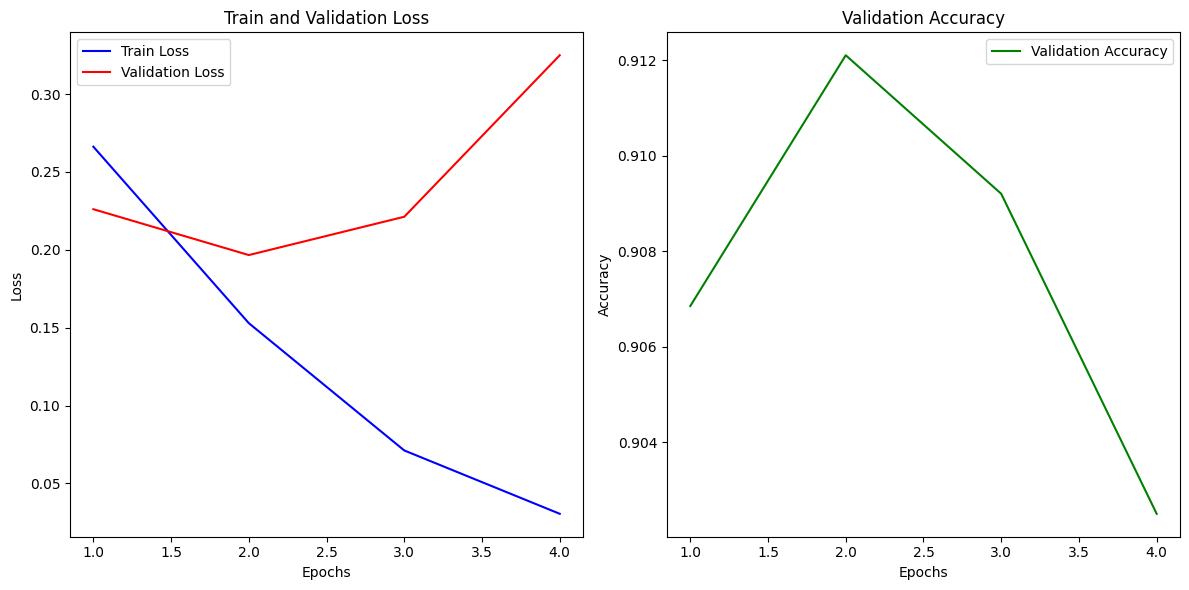

In [19]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Validation Loss: 0.3249
Validation Accuracy: 0.9025
Precision: 0.6242
Recall: 0.6189
F1-Score: 0.6215
Confusion Matrix:
[[16449   964]
 [  986  1601]]


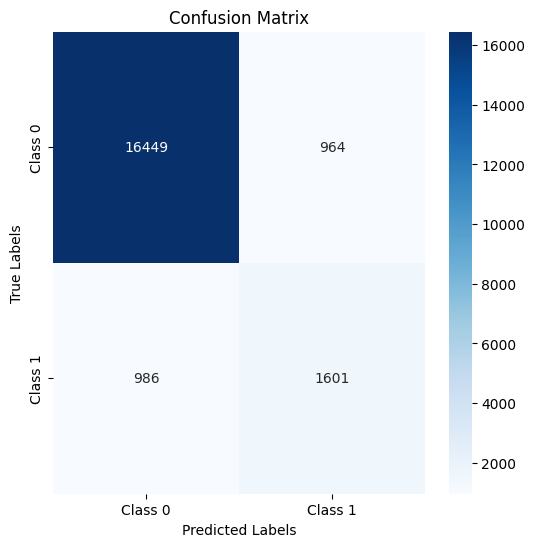

In [20]:
model.eval()  # Ensure the model is in eval mode
total_val_loss = 0
correct_predictions = 0
all_preds = []
all_labels = []
y_probs = []
y_true = []


with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scalar_features = batch['scalar_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()

        # Get predicted labels
        _, predicted = torch.max(outputs, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct_predictions += (predicted == labels).sum().item()

        probs = model.predict_proba(input_ids, attention_mask, scalar_features)
        y_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
        y_true.extend(labels.cpu().numpy())

# Calculate average validation loss and accuracy
avg_val_loss = total_val_loss / len(val_dataloader)
val_accuracy = correct_predictions / len(val_dataloader.dataset)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

# Print evaluation statistics
print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

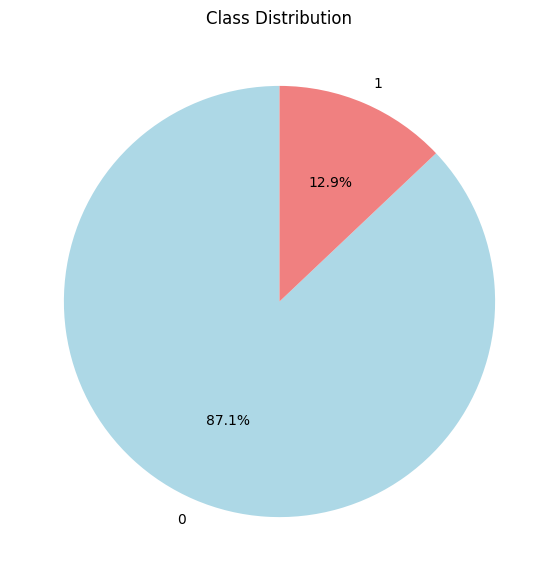

In [21]:
class_counts = processed_training_data['label'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Class Distribution')
plt.show()

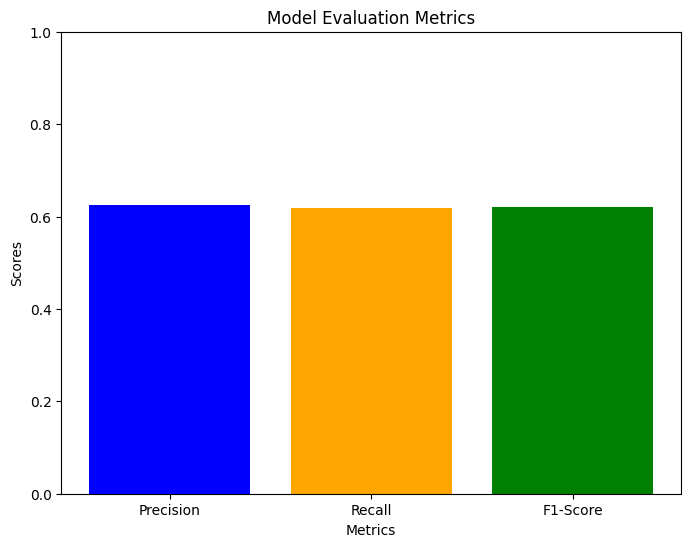

In [22]:
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1]

# Bar chart for evaluation metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.show()

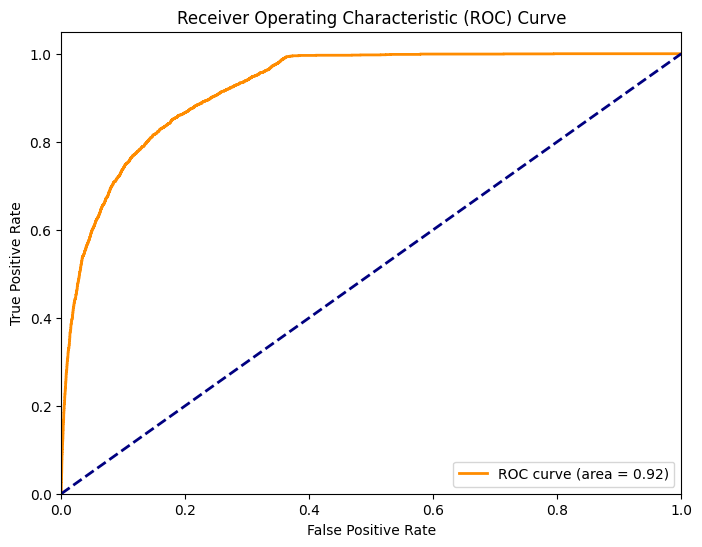

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

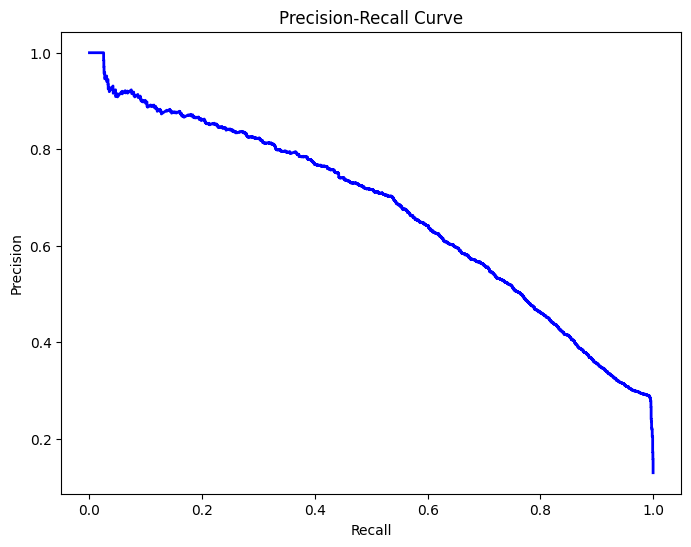

In [24]:
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#### Testing the model on a single comment

In [25]:
test_str = singular_comment_without_annotation("fuck you!")
test_str

{'comment': 'fuck you!',
 'sentiment': 'negative',
 'hate_score': 0.09883923083543777,
 'emotion': 'anger',
 'toxicity': 0.0,
 'obscene': 0.9928935170173645,
 'identity_attack': 0.0,
 'insult': 0.9431484937667847,
 'threat': 0.0037716615479439497,
 'sexual_explicit': 0.0}

In [26]:
def predict_single_comment_with_features(test_dict, model, tokenizer, device):
    model.eval()

    comment = test_dict['comment']

    # 1. Tokenize text
    inputs = tokenizer(comment, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # 2. Build scalar feature vector
    scalar_features = np.array([
        test_dict['hate_score'],
        test_dict['toxicity'],
        test_dict['obscene'],
        test_dict['identity_attack'],
        test_dict['insult'],
        test_dict['threat'],
        test_dict['sexual_explicit'],
        1.0 if test_dict['sentiment'] == 'negative' else 0.0,
        1.0 if test_dict['sentiment'] == 'neutral' else 0.0,
        1.0 if test_dict['sentiment'] == 'positive' else 0.0,
        1.0 if test_dict['emotion'] == 'anger' else 0.0,
        1.0 if test_dict['emotion'] == 'fear' else 0.0,
        1.0 if test_dict['emotion'] == 'joy' else 0.0,
        1.0 if test_dict['emotion'] == 'love' else 0.0,
        1.0 if test_dict['emotion'] == 'sadness' else 0.0,
        1.0 if test_dict['emotion'] == 'surprise' else 0.0
    ], dtype=np.float32)

    scalar_features = torch.tensor(scalar_features).unsqueeze(0).to(device)  # shape (1, 16)

    # 3. Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)
        probs = torch.softmax(outputs, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()

    return pred_label, probs.cpu().numpy()

In [27]:
test_str = singular_comment_without_annotation(clean_comment("suck yor dick! This article is aass!"))
pred_label, probabilities = predict_single_comment_with_features(test_str, model, tokenizer, device)

label_map = {0: "keep", 1: "delete"}
print(f"Predicted label: {label_map[pred_label]}")
print(f"Probabilities: {probabilities}")

Predicted label: delete
Probabilities: [[3.396267e-04 9.996604e-01]]
